In [1]:
import numpy as np
from PIL import Image

def read_images(file_paths):
    X = []
    y = [] # 0 if sober, 1 if drunk
    
    for file_name in file_paths:
        thermal_data = np.zeros((128, 160))
        with Image.open(file_name) as img:
            for i in range(img.n_frames):
                img.seek(i)
                frame_data = np.array(img)
                min_val = np.amin(frame_data)
                frame_data -= min_val
                for j in range(img.height):
                    for k in range(img.width):
                        thermal_data[j, k] += frame_data[j, k]
        X.append(thermal_data)
        
        if '_1_f' in file_name: # Only first pic in series is sober data
            y.append(0)
        else:
            y.append(1)

        print(file_name)
        print(thermal_data)
    return X,y

In [2]:
import os
import glob
import matplotlib as plt

DIR_NAME = 'data'

os.chdir(f'../{DIR_NAME}')
DATA_DIR = os.getcwd()

In [3]:
os.chdir(os.path.join(DATA_DIR,'train'))
HOME = os.getcwd()

import pickle

X_train = None
y_train = None
if os.path.exists('train.pkl'):
    (X_train,y_train) = pickle.load(open('train.pkl', 'rb'))

else:
    # Full filepaths
    file_paths = []
    subjects = glob.glob('*')
    for subject in subjects:
        for i in range(1,5):
            facial_pics = glob.glob(f'{subject}/*{i}_f*') # Look for only face pictures, labeled 1-4
            for partial_path in facial_pics:
                file_paths.append(os.path.join(HOME,partial_path))
            if not facial_pics:
                print(f'{subject}/{i}_f file not found')

    X_train,y_train = read_images(file_paths)
    pickle.dump((X_train,y_train), open('train.pkl', 'wb'))

In [4]:
os.chdir(os.path.join(DATA_DIR,'test'))
HOME = os.getcwd()

X_test = None
y_test = None
if os.path.exists('test.pkl'):
    (X_test,y_test) = pickle.load(open('test.pkl', 'rb'))

else:
    # Full filepaths
    file_paths = []
    subjects = glob.glob('*')
    for subject in subjects:
        for i in range(1,5):
            facial_pics = glob.glob(f'{subject}/*{i}_f*') # Look for only face pictures, labeled 1-4
            for partial_path in facial_pics:
                file_paths.append(os.path.join(HOME,partial_path))
            if not facial_pics:
                print(f'{subject}/{i}_f file not found')

    X_test,y_test = read_images(file_paths)
    pickle.dump((X_test,y_test), open('test.pkl', 'wb'))

In [5]:
os.chdir(os.path.join(DATA_DIR,'validation'))
HOME = os.getcwd()

X_val = None
y_val = None
if os.path.exists('validation.pkl'):
    (X_val,y_val) = pickle.load(open('validation.pkl', 'rb'))

else:
    # Full filepaths
    file_paths = []
    subjects = glob.glob('*')
    for subject in subjects:
        for i in range(1,5):
            facial_pics = glob.glob(f'{subject}/*{i}_f*') # Look for only face pictures, labeled 1-4
            for partial_path in facial_pics:
                file_paths.append(os.path.join(HOME,partial_path))
            if not facial_pics:
                print(f'{subject}/{i}_f file not found')

    X_val,y_val = read_images(file_paths)
    pickle.dump((X_val,y_val), open('validation.pkl', 'wb'))

In [6]:
len(y_val)

24

In [6]:
from imgaug import augmenters as iaa

flip_seq = iaa.Sequential([
    iaa.Fliplr(1), # horizontally flip all of the images
])

trans_seq = iaa.Sequential([
    # iaa.Add((-5, 5)), # randomly +- 5 to pixel values
    iaa.CropAndPad(percent=(-0.1, 0.1)) # https://imgaug.readthedocs.io/en/latest/source/overview/size.html#cropandpad
])

# 'images' should be either a 4D numpy array of shape (N, height, width, channels)
# or a list of 3D numpy arrays, each having shape (height, width, channels).
# Grayscale images must have shape (height, width, 1) each.
# All images must have numpy's dtype uint8. Values are expected to be in
# range 0-255.

# Add flipped images to train and val sets
X_train_flipped = flip_seq(images=X_train)
X_train = np.concatenate((X_train, X_train_flipped), axis=0)
y_train = np.concatenate((y_train, y_train), axis=0)

X_val_flipped = flip_seq(images=X_val)
X_val = np.concatenate((X_val, X_val_flipped), axis=0)
y_val = np.concatenate((y_val, y_val), axis=0)

# Add flipped images to train and val sets
X_train_trans = trans_seq(images=X_train)
X_train = np.concatenate((X_train, X_train_trans), axis=0)
y_train = np.concatenate((y_train, y_train), axis=0)

X_val_trans = trans_seq(images=X_val)
X_val = np.concatenate((X_val, X_val_trans), axis=0)
y_val = np.concatenate((y_val, y_val), axis=0)

# for i,img in enumerate(X_train_flipped):
#     display(Image.fromarray(img*1000).convert('L'))
#     input("Enter to continue:")

len(X_train)

412

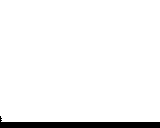

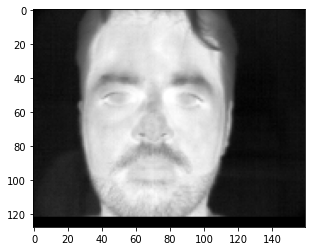

In [8]:
from matplotlib import pyplot
pyplot.imshow(X_train[84], cmap='gray')
display(Image.fromarray(X_train[1]*2000).convert('L'))

In [7]:
import tensorflow as tf

X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)
X_val = tf.keras.utils.normalize(X_val, axis=1)

In [10]:
# Attempt at facial recognition

# import cv2
# HOME = os.getcwd()
# face_cascade = cv2.CascadeClassifier(os.path.join(HOME,'haarcascade_frontalface_alt2.xml'))

# img = X_train[0]*255
# img = np.array(img, dtype='uint8')

# # detect
# faces = face_cascade.detectMultiScale(img, minSize=(50,100), scaleFactor=1.05, minNeighbors=0, flags=cv2.CASCADE_SCALE_IMAGE)

# face_roi = None
# # draw boxes around ROI
# for (x,y,w,h) in faces:
#     face_roi = img[y:y+h,x:x+w]
#     cv2.rectangle(img, (x,y), (x+w,y+h), (0,0,255), 4)
    

# display(Image.fromarray(img))
# if face_roi:
#     display(Image.fromarray(face_roi))

In [8]:
# Shuffle X_train and y_train together
from sklearn.utils import shuffle

def shuffle_data(X, y):
    X_s, y_s = shuffle(X, y)
    return X_s, y_s

In [10]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
import tensorflow.keras.metrics

## Model
model = Sequential()

x,y = X_train.shape[1:]
model.add(Conv2D(256, (3, 3), input_shape=(x,y,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

##

# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics
METRICS = [
      tensorflow.keras.metrics.TruePositives(name='tp'),
      tensorflow.keras.metrics.FalsePositives(name='fp'),
      tensorflow.keras.metrics.TrueNegatives(name='tn'),
      tensorflow.keras.metrics.FalseNegatives(name='fn'), 
      tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),
      tensorflow.keras.metrics.AUC(name='auc'),
      tensorflow.keras.metrics.BinaryCrossentropy(name='bce')
]

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=METRICS)

# from tensorflow.keras.models import load_model
# model = load_model('256_save_best_tn2.epoch=24-val_tn=6.0000.hdf5')

# Get shuffled data and prepare for model.fit inputs
X_train_s, y_train_s = shuffle_data(X_train, y_train)
X_val_s, y_val_s = shuffle_data(X_val, y_val)
input_data = X_train_s.reshape((-1, x, y, 1))
val_data = X_val_s.reshape((-1, x, y, 1))

# Treat every sober image with same weight as 3 drunk images
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
class_weight = {0: (1/4)/2, 1: (3/4)/2}

# save_best_model_loss = tf.keras.callbacks.ModelCheckpoint("best_loss.epoch={epoch:02d}-val_loss={val_loss:.4f}.hdf5", 
#                                                           monitor='val_loss', 
#                                                           verbose=0, save_best_only=True, 
#                                                           save_weights_only=False, 
#                                                           mode='min', save_freq='epoch')
# save_best_model_acc = tf.keras.callbacks.ModelCheckpoint("best_acc.epoch={epoch:02d}-val_acc={val_accuracy:.4f}.hdf5", 
#                                                          monitor='val_accuracy', 
#                                                          verbose=0, save_best_only=True, 
#                                                          save_weights_only=False, 
#                                                          mode='max', save_freq='epoch')
# save_best_model_tn = tf.keras.callbacks.ModelCheckpoint("best_tn.epoch={epoch:02d}-val_tn={val_tn:.4f}.hdf5", 
#                                                         monitor='val_tn', 
#                                                         verbose=0, save_best_only=True, 
#                                                         save_weights_only=False, 
#                                                         mode='max', save_freq='epoch')
# save_best_model_auc = tf.keras.callbacks.ModelCheckpoint("best_auc.epoch={epoch:02d}-val_auc={val_auc:.4f}.hdf5", 
#                                                         monitor='val_auc', 
#                                                         verbose=0, save_best_only=True, 
#                                                         save_weights_only=False, 
#                                                         mode='max', save_freq='epoch')


# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', 
#     verbose=1,
#     patience=50,
#     mode='min',
#     restore_best_weights=True)

# model.fit(input_data, np.array(y_train_s), 
#           batch_size=32, 
#           epochs=1000, 
#           validation_data=(val_data,np.array(y_val_s)), 
#           class_weight=class_weight,
#           callbacks=[early_stopping,save_best_model_loss,save_best_model_acc,save_best_model_tn],
#           use_multiprocessing=True)
###############################################
save_best_model_loss = tf.keras.callbacks.ModelCheckpoint("best_loss2.epoch={epoch:02d}-val_loss={val_loss:.4f}.hdf5", 
                                                          monitor='val_loss', 
                                                          verbose=0, save_best_only=True, 
                                                          save_weights_only=False, 
                                                          mode='min', save_freq='epoch')
save_best_model_acc = tf.keras.callbacks.ModelCheckpoint("best_acc2.epoch={epoch:02d}-val_acc={val_accuracy:.4f}.hdf5", 
                                                         monitor='val_accuracy', 
                                                         verbose=0, save_best_only=True, 
                                                         save_weights_only=False, 
                                                         mode='max', save_freq='epoch')
save_best_model_tn = tf.keras.callbacks.ModelCheckpoint("best_tn2.epoch={epoch:02d}-val_tn={val_tn:.4f}.hdf5", 
                                                        monitor='val_tn', 
                                                        verbose=0, save_best_only=True, 
                                                        save_weights_only=False, 
                                                        mode='max', save_freq='epoch')
save_best_model_auc = tf.keras.callbacks.ModelCheckpoint("best_auc2.epoch={epoch:02d}-val_auc={val_auc:.4f}.hdf5", 
                                                        monitor='val_auc', 
                                                        verbose=0, save_best_only=True, 
                                                        save_weights_only=False, 
                                                        mode='max', save_freq='epoch')
save_best_model_bce = tf.keras.callbacks.ModelCheckpoint("best_bce2.epoch={epoch:02d}-val_bce={val_bce:.4f}.hdf5", 
                                                        monitor='val_bce', 
                                                        verbose=0, save_best_only=True, 
                                                        save_weights_only=False, 
                                                        mode='auto', save_freq='epoch')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=50,
    mode='min',
    restore_best_weights=True)

model.fit(input_data, np.array(y_train_s), 
          batch_size=32, 
          epochs=1000, 
          validation_data=(val_data,np.array(y_val_s)), 
          class_weight=class_weight,
          callbacks=[early_stopping,save_best_model_loss,save_best_model_acc,save_best_model_tn,save_best_model_auc,save_best_model_bce],
          shuffle=True,
          use_multiprocessing=True)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 412 samples, validate on 96 samples
Epoch 1/1000
412/412 [==============================] - 39s 94ms/sample - loss: 0.1389 - tp: 308.0000 - fp: 104.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.7476 - precision: 0.7476 - recall: 1.0000 - auc: 0.5285 - bce: 0.8761 - val_loss: 0.1195 - val_tp: 72.0000 - val_fp: 24.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000 - val_auc: 0.5457 - val_bce: 0.5619
Epoch 2/1000
412/412 [==============================] - 36s 87ms/sample - loss: 0.1123 - tp: 308.0000 - fp: 104.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.7476 - precision: 0.7476 - recall: 1.0000 - auc: 0.4959 - bce: 0.6799 - val_loss: 0.1072 - val_tp: 72.0000 - val_fp: 24.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000 - val_auc: 0.5431 - val_bce: 0.5834
Epoch 3/1000
412/412 [===========

Epoch 20/1000
412/412 [==============================] - 38s 93ms/sample - loss: 0.0212 - tp: 308.0000 - fp: 17.0000 - tn: 87.0000 - fn: 0.0000e+00 - accuracy: 0.9587 - precision: 0.9477 - recall: 1.0000 - auc: 0.9890 - bce: 0.1261 - val_loss: 0.2160 - val_tp: 58.0000 - val_fp: 10.0000 - val_tn: 14.0000 - val_fn: 14.0000 - val_accuracy: 0.7500 - val_precision: 0.8529 - val_recall: 0.8056 - val_auc: 0.7335 - val_bce: 0.9162
Epoch 21/1000
412/412 [==============================] - 37s 91ms/sample - loss: 0.0187 - tp: 305.0000 - fp: 14.0000 - tn: 90.0000 - fn: 3.0000 - accuracy: 0.9587 - precision: 0.9561 - recall: 0.9903 - auc: 0.9917 - bce: 0.1051 - val_loss: 0.1931 - val_tp: 57.0000 - val_fp: 10.0000 - val_tn: 14.0000 - val_fn: 15.0000 - val_accuracy: 0.7396 - val_precision: 0.8507 - val_recall: 0.7917 - val_auc: 0.7648 - val_bce: 0.8683
Epoch 22/1000
412/412 [==============================] - 39s 94ms/sample - loss: 0.0195 - tp: 307.0000 - fp: 23.0000 - tn: 81.0000 - fn: 1.0000 - accu

412/412 [==============================] - 38s 92ms/sample - loss: 2.3496e-04 - tp: 308.0000 - fp: 0.0000e+00 - tn: 104.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - bce: 0.0014 - val_loss: 0.4909 - val_tp: 51.0000 - val_fp: 9.0000 - val_tn: 15.0000 - val_fn: 21.0000 - val_accuracy: 0.6875 - val_precision: 0.8500 - val_recall: 0.7083 - val_auc: 0.7445 - val_bce: 1.7525
Epoch 40/1000
412/412 [==============================] - 39s 95ms/sample - loss: 2.2822e-04 - tp: 308.0000 - fp: 0.0000e+00 - tn: 104.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - bce: 0.0010 - val_loss: 0.4794 - val_tp: 52.0000 - val_fp: 9.0000 - val_tn: 15.0000 - val_fn: 20.0000 - val_accuracy: 0.6979 - val_precision: 0.8525 - val_recall: 0.7222 - val_auc: 0.7439 - val_bce: 1.7568
Epoch 41/1000
412/412 [==============================] - 37s 89ms/sample - loss: 2.1931e-04 - tp: 308.0000 - fp: 0.0000e+00 - tn: 104.0000 - fn: 0

Epoch 58/1000
412/412 [==============================] - 38s 93ms/sample - loss: 5.9117e-05 - tp: 308.0000 - fp: 0.0000e+00 - tn: 104.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - bce: 3.2538e-04 - val_loss: 0.5830 - val_tp: 51.0000 - val_fp: 9.0000 - val_tn: 15.0000 - val_fn: 21.0000 - val_accuracy: 0.6875 - val_precision: 0.8500 - val_recall: 0.7083 - val_auc: 0.7228 - val_bce: 2.0853
Epoch 59/1000
412/412 [==============================] - 37s 91ms/sample - loss: 5.7070e-05 - tp: 308.0000 - fp: 0.0000e+00 - tn: 104.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - bce: 3.0833e-04 - val_loss: 0.6091 - val_tp: 51.0000 - val_fp: 8.0000 - val_tn: 16.0000 - val_fn: 21.0000 - val_accuracy: 0.6979 - val_precision: 0.8644 - val_recall: 0.7083 - val_auc: 0.7381 - val_bce: 2.1335
Epoch 60/1000
412/412 [==============================] - 39s 93ms/sample - loss: 5.3251e-05 - tp: 308.0000 - fp: 0.0000e+00 

35/35 [==============================] - 2s 44ms/sample - loss: 0.7521 - tp: 24.0000 - fp: 6.0000 - tn: 2.0000 - fn: 3.0000 - accuracy: 0.7429 - precision: 0.8000 - recall: 0.8889 - auc: 0.6736 - bce: 0.7521
Accuracy: 0.7428571428571429
Confusion Matrix:
[[ 2  6]
 [ 3 24]]
Actual: 1, Pred: 1
Actual: 1, Pred: 0
Actual: 0, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 0
Actual: 0, Pred: 0


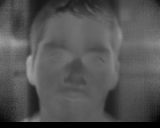

Enter for next true negative:
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 0, Pred: 0


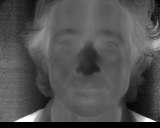

Enter for next true negative:
Actual: 1, Pred: 1
Actual: 1, Pred: 0
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 0, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 0, Pred: 1
Actual: 1, Pred: 1
Actual: 0, Pred: 1
Actual: 1, Pred: 1
Actual: 1, Pred: 1
Actual: 0, Pred: 1
Actual: 0, Pred: 1


In [15]:
# Manually load best saved model here and test
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import load_model
model = load_model('best_tn2.epoch=24-val_tn=16.0000.hdf5')

X_test_s, y_test_s = shuffle_data(X_test, y_test)
test_data = X_test_s.reshape((-1, x, y, 1))
model.evaluate(test_data, np.array(y_test_s))

y_pred = []
predictions = model.predict(test_data)
for predict in predictions:
    y_pred.append(int(round(predict[0])))

print(f'Accuracy: {accuracy_score(y_test_s,y_pred)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test_s,y_pred)}')

for i,(actual,pred) in enumerate(zip(y_test_s,y_pred)):
    print(f'Actual: {actual}, Pred: {pred}')
    
    if actual==0 and actual==pred:
        display(Image.fromarray(X_test_s[i]*1000).convert('L'))
        input('Enter for next true negative:')

In [ ]:
y_pred